In [1]:
%pylab inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import json
from configparser import ConfigParser

import cosmology
import numpy as np
import astropy.io.fits as pyfits
import astropy.table as astTable

import haloSim
from haloSim import TophatAtom
from pixel3D import cartesianGrid3D

if True:
    figMsDir='/work/xiangchong.li/work/massMapSparse/sim/plot/'
else:
    figMsDir='/home/xiangchong/.local/code/massMap_Private/doc/paper_ms_method_HSCY1/'

Populating the interactive namespace from numpy and matplotlib


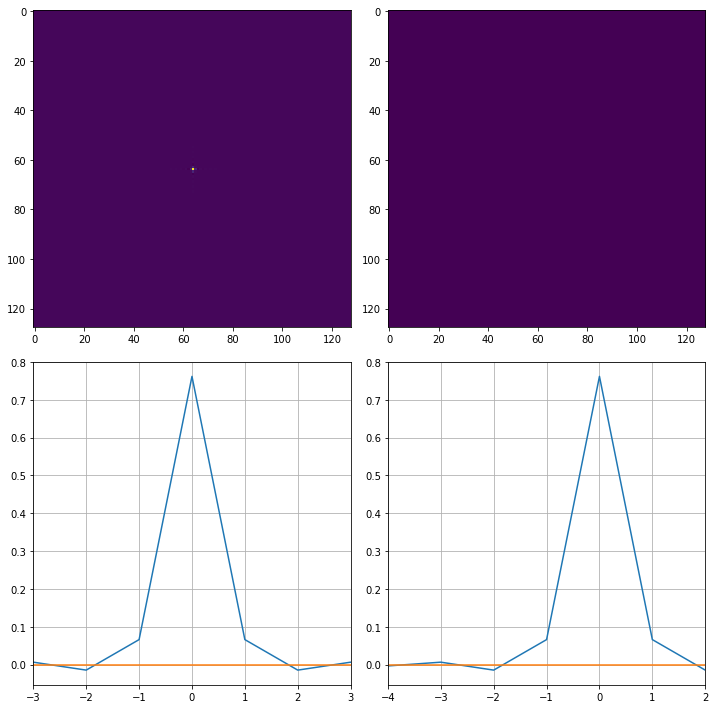

In [2]:
# top-hat filter test
if True:
    width=1
    tpAtomF=TophatAtom(width=width,ny=128)
    tpAtom=np.fft.fftshift(np.fft.ifft2(tpAtomF)).real
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(2,2,1)
    ax.imshow(tpAtom)
    ax=fig.add_subplot(2,2,2)
    tpAtom2=TophatAtom(width=width,ny=128,fou=False)
    ax.imshow(tpAtom2)

    ax=fig.add_subplot(2,2,3)
    ax.plot(np.arange(-64,64),tpAtom[:,64])
    ax.plot(np.arange(-64,64),tpAtom2[:,64])
    ax.grid()
    ax.set_xlim(width//2-3,width//2+3)
    ax=fig.add_subplot(2,2,4)
    ax.plot(np.arange(-64,64),tpAtom[:,64])
    ax.plot(np.arange(-64,64),tpAtom2[:,64])
    ax.grid()
    ax.set_xlim(-width//2-3.,-width//2+3.)

    plt.tight_layout()

# Pixelization

+ Analytical field
    + Pixelize Sigma Field into grids
    + Check Pixelized Sigma with Modelled Sigma filtered by top-hat filter


+ Random Field
    + individual galaxy level
    + individual pixel level


## Pixelize Shear into Grids
### Sampling distance and smoothing scale

| Paper             | pixel            | transverse Gaussian  |  line-of-sight   |
|:-----------------:|:----------------:|:-------------------:|:----------------:|
|HSC (Oguri)   2D KS|     0.5'         |         2'          |      $+\infty$   |
|HSC (Oguri)   3D WF|     1'           |        20'          |      0.1         |
|DES (Chang)   2D KS|      5'          |        0'           |      $+\infty$   |
|DES (Jeffrey) 2D KS|    4.11'         |        0'           |      $+\infty$   |
|DES (Jeffrey) 2D GL|  3' (output)     |        0'           |      $+\infty$   |
|This Work          |  1'              |       1.5'          |      equal Number|

The Glimpse in DES (Jeffrey) does not pixelize input shear map but the output density map is pixelized.

### Pixelize for spin-0 $2$-D $\Sigma$ field

In [54]:
# halo number
iz  =  2
im  =  4
# halo
haloCat=astTable.Table.read('wrkDir/sim/planck-cosmo/nfw-halos/haloCat-202010032144.csv')
msk=(haloCat['im']==im)&(haloCat['iz']==iz)
mass=10**(haloCat[msk]['log10_M200'])
zh=haloCat[msk]['zh']
conc=haloCat[msk]['conc']
halo=haloSim.nfw_lensTJ03(mass=mass,conc=conc,redshift=zh,ra=0.,dec=0.)
# noise catalog
infname='wrkDir/sim/HSC-obs/20200328/stampSim_HSClike_mask_shapenoise_photoz-202003282257.fits'
data=astTable.Table.read(infname)
print('number of loaded noise: %d' %len(data))
ng=len(data)//100
dataU=data[:ng]
# mock catalog
SigmaArray  =   halo.Sigma(dataU['raR']*3600.,dataU['decR']*3600.)
# pixelization
configName  =   'wrkDir/sim/planck-cosmo/config-pix48-nl20.ini'
parser      =   ConfigParser()
parser.read(configName)
parser.set('sourceZ','zbound','[0.02,10]')
cg=cartesianGrid3D(parser)
pixSigma=cg.pixelize_data(dataU['raR'],dataU['decR'],None,SigmaArray)[0]
norm=np.sqrt(np.sum(pixSigma**2.))
pixSigma/=norm

number of loaded noise: 8257800


input smoothing scale: 0.0 pixel
The RMS of residuals is 0.004004998688596831
The max of residuals is 0.010565821196821042


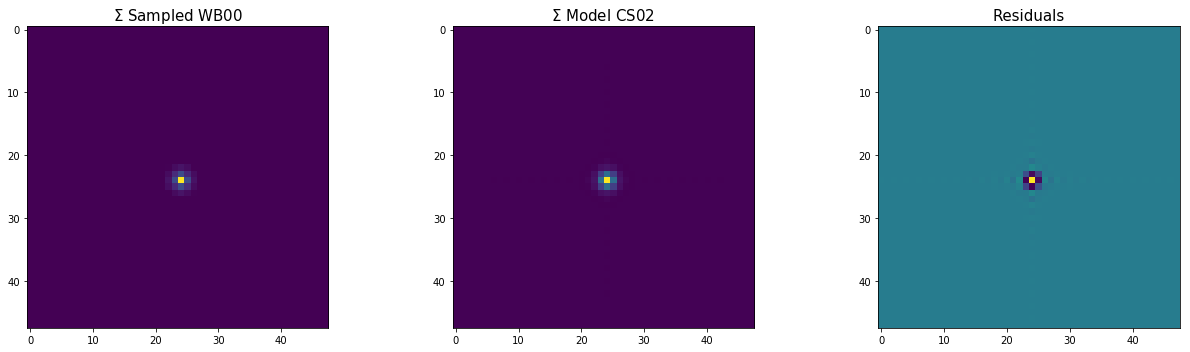

In [55]:
# model
SigmaAtom=np.fft.fftshift(haloSim.haloCS02SigmaAtom(r_s=halo.rs_arcsec/3600./cg.delta,ny=cg.shape[1],c=halo.c,smooth_scale=0,fou=False))
print('input smoothing scale: %s pixel' %(0.))
norm=np.sqrt(np.sum(SigmaAtom**2.))
SigmaAtom/=norm
fig=plt.figure(figsize=(18,5))
ax=fig.add_subplot(1,3,1)
ax.imshow(pixSigma)
ax.set_title(r'$\Sigma$ Sampled WB00',fontsize=15)

ax=fig.add_subplot(1,3,2)
ax.imshow(SigmaAtom)
ax.set_title(r'$\Sigma$ Model CS02',fontsize=15)

ax=fig.add_subplot(1,3,3)
ax.imshow(pixSigma-SigmaAtom)
ax.set_title('Residuals',fontsize=15)
plt.tight_layout()
print('The RMS of residuals is %s' %np.sqrt(np.average((pixSigma-SigmaAtom)**2.)))
print('The max of residuals is %s' %np.max((pixSigma-SigmaAtom)**2.))

input smoothing scale: -100 pixel
The RMS of residuals is 0.0017092261525669685
The max of residuals is 0.0012328735692857258


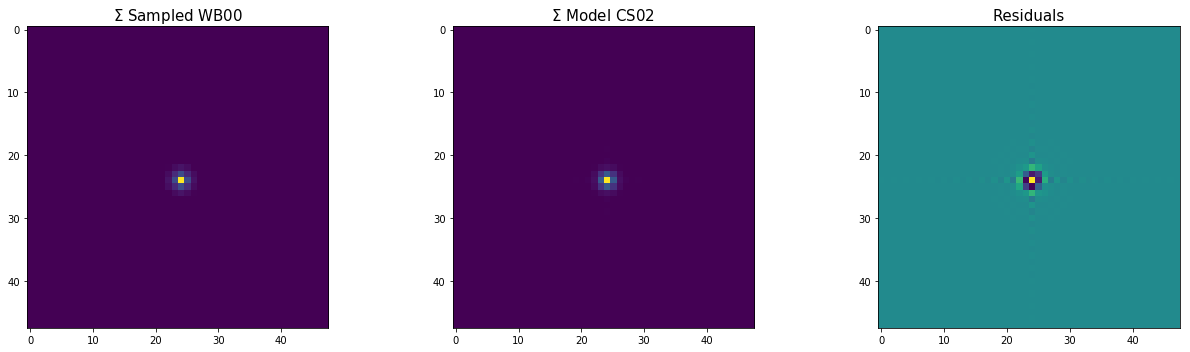

In [56]:
SigmaAtom=np.fft.fftshift(haloSim.haloCS02SigmaAtom(r_s=halo.rs_arcsec/3600./cg.delta,ny=cg.shape[1],c=halo.c,smooth_scale=-100,fou=False))
print('input smoothing scale: %s pixel' %(-100))
norm=np.sqrt(np.sum(SigmaAtom**2.))
SigmaAtom/=norm
fig=plt.figure(figsize=(18,5))
ax=fig.add_subplot(1,3,1)
ax.imshow(pixSigma)
ax.set_title(r'$\Sigma$ Sampled WB00',fontsize=15)

ax=fig.add_subplot(1,3,2)
ax.imshow(SigmaAtom)
ax.set_title(r'$\Sigma$ Model CS02',fontsize=15)

ax=fig.add_subplot(1,3,3)
ax.imshow(pixSigma-SigmaAtom)
ax.set_title('Residuals',fontsize=15)
plt.tight_layout()
print('The RMS of residuals is %s' %np.sqrt(np.average((pixSigma-SigmaAtom)**2.)))
print('The max of residuals is %s' %np.max((pixSigma-SigmaAtom)**2.))

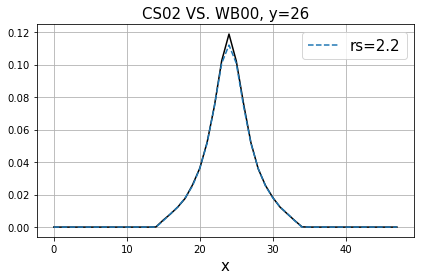

In [62]:
yshow=26
plt.title('CS02 VS. WB00, y=%d' %yshow,fontsize=15)
plt.plot(pixSigma[yshow],'-',c='black')
plt.plot(SigmaAtom[yshow],'--',label=r'rs=%.1f' %(halo.rs_arcsec/3600./cg.delta))
plt.xlabel('x',fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.tight_layout()

## Pixelize noise field

In [76]:
# pixelize data into 3D cartesian coordinates

raname='raR'
decname='decR'
zname='zbest'
g1name='g1n'
g2name='g2n'

configName  =   'wrkDir/sim/planck-cosmo/config-pix48-nl8.ini'
parser      =   ConfigParser()
parser.read(configName)
parser.set('transPlane','smooth_scale','-1')
gridInfo    =   cartesianGrid3D(parser)

ngroup=50 # groups in the input fits file
pixDatAll=np.zeros((ngroup,)+gridInfo.shape)

infname='wrkDir/sim/HSC-obs/20200328/stampSim_HSClike_mask_shapenoise_photoz-202003282257.fits'
noiTab=astTable.Table.read(infname)
ng=len(noiTab)//ngroup

for ig in range(ngroup):
    noiU=noiTab[ig*ng:(ig+1)*ng]
    val=noiU[g1name]
    pixDatAll[ig]=gridInfo.pixelize_data(noiU[raname],noiU[decname],noiU[zname],val)
pixNum=gridInfo.pixelize_data(noiU[raname],noiU[decname],noiU[zname])
msk=pixNum>=1.

Pixel level:
ave:  -0.00018586047216483464
std:  0.2823827091708759
Galaxy level:
ave:  -0.00018586047216483464
std:  0.2823827091708759


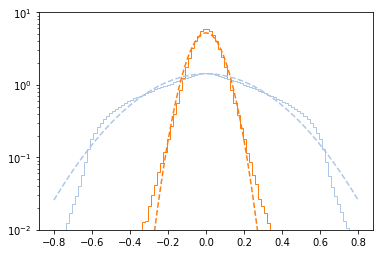

In [79]:
from scipy.stats import norm
cmap=plt.get_cmap('tab20')

dataAll=np.ravel(pixDatAll[:,msk])
gbin=plt.hist(dataAll,range=(-0.8,0.8),bins=100,histtype='step',density=True,color=cmap(2))[1]
gPDF=(gbin-np.average(dataAll))/np.std(dataAll)
a=norm.pdf(gPDF)
plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(2),ls='--')
dataAll=noiTab[g1name]
gbin=plt.hist(dataAll,range=(-0.8,0.8),bins=100,histtype='step',density=True,color=cmap(1))[1]
gPDF=(gbin-np.average(dataAll))/np.std(dataAll)
a=norm.pdf(gPDF)
plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(1),ls='--')
plt.yscale('log')
plt.ylim(1e-2,10)

print('Pixel level:')
print('ave: ',np.average(dataAll))
print('std: ',np.std(dataAll))
print('Galaxy level:')
print('ave: ',np.average(noiTab[g1name]))
print('std: ',np.std(noiTab[g1name]))